Image Deconvolution (ADMM Plug-and-Play Priors w/ DnCNN)
========================================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.optimize.rst#scico.optimize.ADMM) to
solve an image deconvolution problem using the Plug-and-Play Priors
framework <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, using DnCNN
<cite data-cite="zhang-2017-dncnn"/> as a denoiser.

In [1]:
import numpy as np

import jax

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
np.random.seed(1234)
x_gt = discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=512)
x_gt = jax.device_put(x_gt)  # convert to jax array, push to GPU

Set up forward operator and test signal consisting of blurred signal
with additive Gaussian noise.

In [3]:
n = 5  # convolution kernel size
σ = 20.0 / 255  # noise level

psf = snp.ones((n, n)) / (n * n)
A = linop.Convolve(h=psf, input_shape=x_gt.shape)

Ax = A(x_gt)  # blurred image
noise, key = scico.random.randn(Ax.shape, seed=0)
y = Ax + σ * noise

Load DnCNN denoiser and create map object.

In [4]:
λ = 15.0 / 255  # regularization strength
g = λ * functional.DnCNN("17M")

Set up an ADMM solver.

In [5]:
ρ = 1.0  # ADMM penalty parameter
maxiter = 10  # number of ADMM iterations

f = loss.SquaredL2Loss(y=y, A=A)
C = linop.Identity(x_gt.shape)

solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=A.T @ y,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 30}),
    itstat_options={"display": True},
)

Run the solver.

In [6]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  2.65e+00  1.327e+01  1.563e+01      3  2.084e-04


   1  3.17e+00  5.145e+00  1.098e+01      3  3.045e-04


   2  3.58e+00  2.334e+00  8.626e+00      2  8.999e-04


   3  3.98e+00  1.764e+00  6.986e+00      2  6.109e-04


   4  4.51e+00  1.500e+00  5.653e+00      2  4.486e-04


   5  5.04e+00  1.273e+00  4.577e+00      2  3.320e-04


   6  5.55e+00  1.058e+00  3.729e+00      2  2.498e-04


   7  6.04e+00  8.617e-01  3.080e+00      2  1.914e-04


   8  6.66e+00  5.992e-01  2.532e+00      1  9.964e-04


   9  7.22e+00  5.792e-01  2.238e+00      1  5.349e-04


Show the recovered image.

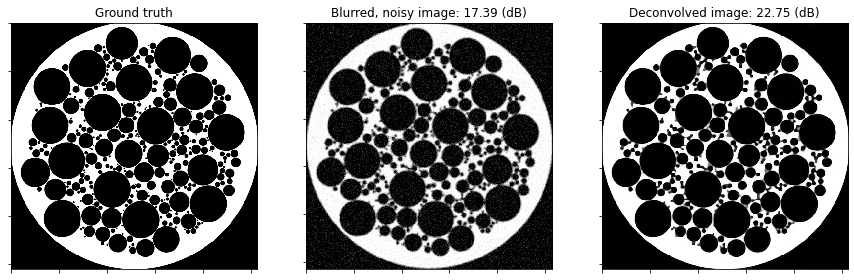

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
y = snp.clip(y, 0, 1)
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(y, title="Blurred, noisy image: %.2f (dB)" % metric.psnr(x_gt, yc), fig=fig, ax=ax[1])
plot.imview(x, title="Deconvolved image: %.2f (dB)" % metric.psnr(x_gt, x), fig=fig, ax=ax[2])
fig.show()

Plot convergence statistics.

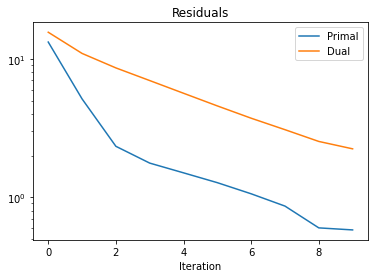

In [8]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)